In [1]:
from bioblend.galaxy import GalaxyInstance
import pandas as pd
from io import StringIO
import os
import requests
import seaborn as sns

# Add galaxy API key
Add `GALAXY_API_KEY` from `https://usegalaxy.eu/user/api_key` via `export GALAXY_API_KEY="<key>"` or `%env  GALAXY_API_KEY=<key>` in jupyter

In [2]:
%env GALAXY_API_KEY=

env: GALAXY_API_KEY=88c98d1c08f608ace9cbf5fd766eda96


In [3]:
history_id = "a90a5dd2a4c17493"
collection_name = "Kraken2 with PlusPF database output report"

gi = GalaxyInstance(url='https://usegalaxy.eu/', key=os.environ['GALAXY_API_KEY'])

datasets = gi.datasets.get_datasets(name = collection_name, history_id = history_id)

#print(datasets)

#fetch collection by name
if len(datasets) > 1:
    print("too many datasets with that name")

for dataset in datasets:
    if dataset['history_content_type']=='dataset_collection': #get only collections
        if dataset['job_state_summary']['all_jobs'] == dataset['job_state_summary']['ok']: #get only collections where all jobs are ok
            dataset_collection_id = dataset["id"]


# get data of the elements in the collection
collection = gi.dataset_collections.show_dataset_collection(dataset_collection_id = dataset_collection_id)




too many datasets with that name


In [4]:
dfs = []

for element in collection['elements']:

    element_name = element['element_identifier']

    print(element_name)
    element_id = element['object']['id']
    data = gi.datasets.download_dataset(element_id, maxwait = 3)
    df = pd.read_csv(StringIO(data.decode("utf-8")), sep="\t", header=None)

    # get only species
    df = df.loc[(df.iloc[:,3] == "S")]

    #set taxa as index without space
    df.index = df.iloc[:,5].str.replace(" ","")

    # get only abundance for the sample
    df = df.iloc[:,0]

    df.name = element_name

    dfs.append(df)


Spike1Barcode10
Spike1Barcode11
Spike1Barcode12
Spike1Barcode13
Spike1Barcode14
Spike1Barcode15
 Spike2Barcode10
Spike2Barcode11
Spike2Barcode12
Spike2Barcode13
Spike2Barcode14
Spike2Barcode15
Spike2bBarcode10
Spike2bBarcode11
Spike2bBarcode12
Spike2bBarcode13
Spike2bBarcode14
Spike2bBarcode15
Spike2bUnclassified
Spike3Barcode11
Spike3Barcode13
Spike3Barcode14
Spike3Barcode15
Spike3Unclassified
Spike3bBarcode10
Spike3bBarcode12
Spike3bBarcode11
Spike3bBarcode13
Spike3bBarcode14
Spike3bUnclassified
Spike3bBarcode15
Spike4Barcode01
Spike4Barcode02
Spike4Barcode03
Spike4Barcode04
Spike4Barcode05
Spike4Barcode07
Spike4Barcode08
Spike4Barcode10
Spike4Barcode11
Spike4Barcode12
Spike4Barcode13
Spike4Barcode14
Spike4Barcode15
Spike4Barcode16
Spike4Unclassified


In [5]:
#taxa that do not exist in one of the dfs get filled with zero
main_df = pd.concat(dfs, join="outer", axis = 1)
main_df.fillna(0, inplace=True)

main_df.index.name = "species"

outpath = "data/output"
os.makedirs(outpath)

main_df.to_csv(os.path.join(outpath,"kraken_species_abundance_bio.csv"))

FileExistsError: [Errno 17] File exists: 'data/output'

In [6]:
#normalize
main_df = pd.read_csv(os.path.join(outpath,"kraken_species_abundance_bio.csv"), index_col=0)

# Normalize between 0 and 1
main_df = main_df.apply(lambda x: x/sum(x),axis = 0)
print(main_df.shape)

# remove species where for no sample more than 0.02 abundance is present
main_df = main_df.loc[(main_df>=0.01).any(axis=1)]
print(main_df.shape)


(233, 46)
(22, 46)


In [8]:
# add metadata

meta_df = pd.read_excel(open('data/FoodbornePathogenDetectionDataAnalysis.xlsx', 'rb'), sheet_name='Biolytix Spiked') 
meta_df.set_index("Galaxy ID", inplace=True)
meta_df.index.name = "Name"

main_df_columns = main_df.columns

frames = [main_df, meta_df]
result = pd.concat(frames, axis = 1)

# remove 

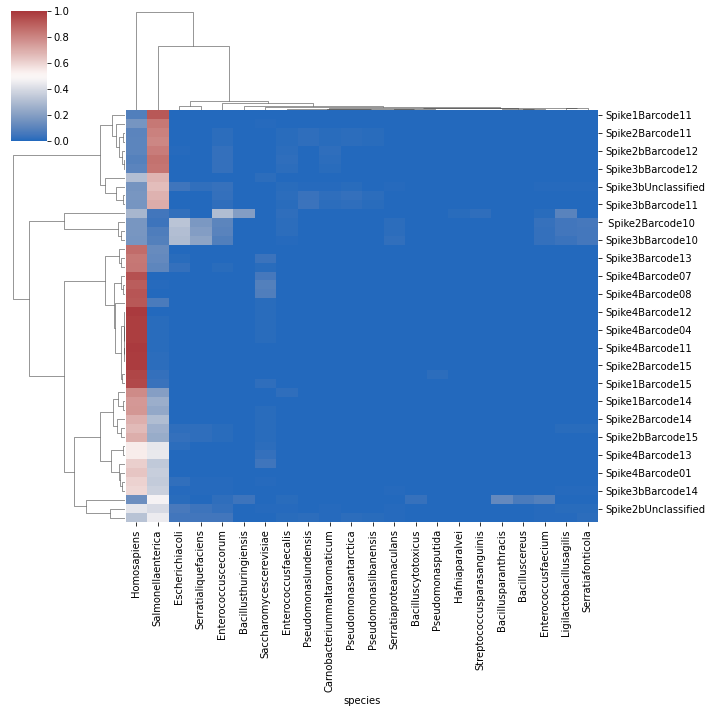

In [9]:
# plot
main_df = main_df.transpose()

# sns.heatmap(main_df, cmap = )
sns.clustermap(main_df, cmap="vlag", vmin=0, vmax=1, xticklabels=True)